# Video: Computing Maximum Return, Minimum Risk, and Target Return Portfolios

Given a risk-return model, the maximum return and minimum risk portfolios can be easily computed.
This video will walk you through that process using the CVXPY Python library.

Script:
* I am going to show you how to compute different interesting portfolios using linear and quadratic programming solvers.
* I will start with the maximum return and minimum risk portfolios and show you how to construct them easily with the CVXPY Python library.
* The maximum return portfolio will be chosen solely based on returns.
* And the minimum risk portfolio will be chosen solely based on risks.
* Then I will show you how to pick portfolios in between that achieve a given return with the minimum possible risk.
* That optimization will require considerations of both risk and return to be balanced, but you will see that the optimization library can easily handle it for us.
* Let's get started.


In [ ]:
# adjusted closing price data from
# https://finance.yahoo.com/quote/AAPL/history/
# https://finance.yahoo.com/quote/SPY/history/
# https://finance.yahoo.com/quote/TSLA/history/

import pandas as pd

historical_prices_url = "https://raw.githubusercontent.com/bu-cds-omds/dx704-examples/refs/heads/main/data/prices-monthly.tsv"
historical_prices = pd.read_csv(historical_prices_url, sep="\t")
historical_prices = historical_prices.set_index("date")

historical_returns = historical_prices.pct_change().dropna()
estimated_returns = historical_returns.mean().rename("return")

estimated_covariance = historical_returns.cov()

Script:
* I already loaded our historical data and estimated the returns and covariances of our risk model.
* Let's take a look.

In [ ]:
estimated_returns

,return
AAPL,0.010874
SPY,0.005057
TSLA,0.057663


Script:
* And here are the covariances.

In [ ]:
estimated_covariance

,AAPL,SPY,TSLA
AAPL,0.003129,0.000929,0.004328
SPY,0.000929,0.001052,0.003264
TSLA,0.004328,0.003264,0.033465


Script:
* We will use the CVXPY library to optimize our portfolios.

In [ ]:
import cvxpy as cp

Script:
* The first question setting up the optimization will be, how many variables are being optimized?
* Our variables will be the allocations of each asset, so we will have one variable per asset.

In [ ]:
# number of assets
n = len(estimated_returns)

Script:
* CVXPY has its own representation to track variables which we will initialize with the number of variables.

In [ ]:
# create variables to optimize
x = cp.Variable(n)

Script:
* Next we will create the objective function.
* There is one idiosyncracy converting the pandas data frame to a NumPy array to reshape it, but otherwise it looks like NumPy array manipulation.

In [ ]:
objective = cp.Maximize(estimated_returns.to_numpy().reshape(1, -1) @ x)
objective

Maximize(Expression(AFFINE, UNKNOWN, (1,)))

Script:
* That output is a brief summary of the objective function setup.
* We asked it to maximize the objective, and the word affine there includes linear functions.
* If we are picky, affine functions allow additive constants while linear functions do not, but most of the time those are all casually referred to as linear.
* Now we create the linear programming problem combining the objective function that we just made with some constraints.



In [ ]:
# formulate linear program
prob = cp.Problem(objective,
                  [0 <= x,
                   cp.sum(x) == 1])

Script:
* These need to use the CVXPY functions to construct sum constraints in a way that they can be re-evaluated later, but otherwise they should be pretty straightforward.
* Roughly speaking, any time you would use np.something you should probably use cp.something instead.
* Now we can just solve the problem and get the best objective value back.

In [ ]:
estimated_return_P = prob.solve()
estimated_return_P

0.05766262507640715

Script:
* The objective function that we maximized was expected return, so that objective value returned is the expected return of the portfolio just optimized.
* Does that estimated return number looks familiar?
* It is the same as TSLA.
* Let's look at the asset weights.

In [ ]:
x.value

array([2.61628173e-09, 4.87516794e-09, 9.99999993e-01])

Script:
* The optimized portfolio is all in on the Tesla stock with negligible allocations to the other assets (really numerical error).
* Rounding makes this clear.

In [ ]:
x.value.round(2)

array([0., 0., 1.])

Script:
* Also note, this was a maximum *monthly* return of almost 6%.
* Ignoring risk, that compounds to about 96% annual return.


Script: (faculty on camera, something in the background flashing red warning lights)
* Is that really realistic?
* It's a perfect example of why ignoring risk may lead to outright dangerous investment decisions.
* So let's look at the other side now, and construct the minimum risk portfolio.

Script:
* We will need separate variables for this optimization, so I'll create them now with a different name for clarity.

In [ ]:
# create variables for minimum risk optimization
x_minimum_risk = cp.Variable(n)

Script:
* Now we will create the objective function which looks similar to before, but with more matrix multiplications since this objective is quadratic instead of linear.

In [ ]:
objective_minimum_risk = cp.Minimize(x_minimum_risk.T @ estimated_covariance.to_numpy() @ x_minimum_risk)
objective_minimum_risk

Minimize(Expression(CONVEX, NONNEGATIVE, ()))

Script:
* One thing to note here is that CVXPY classified this function as convex.
* Practically, that means that this function can easily be optimized.
* If it was not convex, it would be hard to guarantee an optimal solution.
* So convex objective functions are generally good.
* Let's complete the problem and solve it now.

In [ ]:
# formulate minimum risk program
prob_minimum_risk = cp.Problem(objective_minimum_risk,
                               [0 <= x_minimum_risk,
                                cp.sum(x_minimum_risk) == 1])

covariance_minimum_risk = prob_minimum_risk.solve()
covariance_minimum_risk

np.float64(0.0010455770496877266)

Script:
* That's a small number.
* How does it compare to the individual asset covariances?

##

* TODO compare minimum risk vs individual assets

Script:
* That minimum portfolio variance is slightly lower than the covariance of SPY, and much lower than the covariances of the other assets.
* The minimum portfolio variance should never have more than the variance than any asset unless the constraints block only allocating that asset.
* Otherwise, picking that asset 100% would be a lower variance counter example.
* What does this minimum variance portfolio look like?

In [ ]:
x_minimum_risk.value.round(2)

array([0.05, 0.95, 0.  ])

Script:
* It is 95% SPY, 5% AAPL, and no TSLA.
* If you are familiar with those tickers, that makes sense.
* SPY is an index fund based on the S&P 500 index, while TSLA is for Tesla which has been pretty volatile throughout its history, but especially in the early parts of 2025.
* The last ticker, AAPL, is for Apple.

Script:
* What is the return of this minimum risk portfolio?

In [ ]:
estimated_returns = historical_returns.mean()
estimated_returns

,0
AAPL,0.010874
SPY,0.005057
TSLA,0.057663


In [ ]:
estimated_return_minimum_risk = x_minimum_risk.value.T @ estimated_returns
estimated_return_minimum_risk

np.float64(0.005364443384876672)

It is slightly higher than SPY's estimated return; AAPL pulls up the average despite only 5% weight.
Still, the higher return of TSLA is nowhere to be seen since the minimum risk portfolio completely avoided that asset.

In [ ]:
target_return = 0.03

# create variables to optimize
x_target_return = cp.Variable(n)

# formulate linear program
prob_target_return= cp.Problem(cp.Minimize(x_target_return.T @ historical_covariance.to_numpy() @ x_target_return),
                               [0 <= x_target_return,
                                cp.sum(x_target_return) == 1,
                                x_target_return.T @ estimated_returns == target_return])

covariance_target_return = prob_target_return.solve()
covariance_target_return

np.float64(0.008768234579726837)

That covariance is much smaller than the TSLA covariance to achieve maximum return.

Let's double check the return - was the target hit?

In [ ]:
estimated_return_target_return = x_target_return.value.T @ estimated_returns
estimated_return_target_return

np.float64(0.029999999999999995)

Close enough!
Now let's compare the optimized portfolios so far with the individual assets.

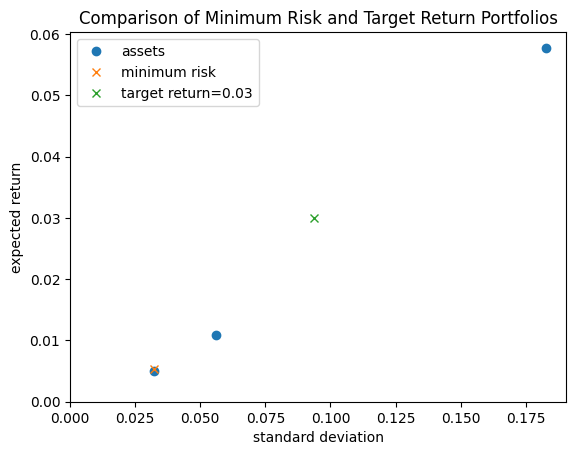

In [ ]:
import matplotlib.pyplot as plt

estimated_variances = historical_returns.var()
plt.plot(np.sqrt(estimated_variances), estimated_returns, label="assets", linestyle="none", marker="o")

plt.plot(np.sqrt(covariance_minimum_risk), estimated_return_minimum_risk, label="minimum risk", linestyle="none", marker="x")
plt.plot(np.sqrt(covariance_target_return), estimated_return_target_return, label=f"target return={target_return:.2f}", linestyle="none", marker="x")

plt.legend()
plt.xlabel("standard deviation")
plt.xlim(0)
plt.ylabel("expected return")
plt.ylim(0)
plt.title("Comparison of Minimum Risk and Target Return Portfolios")
plt.show();


Script:
* TODO